In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle 

from sklearn.model_selection import train_test_split,KFold, cross_val_score,GridSearchCV,cross_val_predict,RepeatedStratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.metrics import f1_score, accuracy_score,classification_report, confusion_matrix,precision_score,recall_score,roc_auc_score
from sklearn.metrics import plot_confusion_matrix, precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve,auc,roc_curve

from sklearn.feature_selection import RFE




## Loading the clean data 

In [6]:
df_2018= pd.read_csv('fin_inpdata2018.csv')

df_2017= pd.read_csv('fin_inpdata2017.csv')

df=pd.concat([df_2018, df_2017], axis=0)

In [7]:
df

,MAGER,PRIORLIVE,PRIORDEAD,PRIORTERM,LBO_REC,TBO_REC,ILLB_R11,ILP_R11,PRECARE,PREVIS,...,RF_INFTR,RF_FEDRG,RF_ARTEC,RF_CESARN,IP_GON,IP_SYPH,IP_CHLAM,IP_HEPATB,IP_HEPATC,comb
0,26,1,0,0,2,2,5,5,2,13,...,N,X,X,0,N,N,N,N,N,0
1,29,2,0,0,3,3,6,6,2,14,...,N,X,X,0,N,N,N,N,N,0
2,31,3,0,1,4,5,4,2,3,10,...,N,X,X,0,N,N,N,N,N,0
3,34,0,0,2,1,3,9,8,3,13,...,N,X,X,0,N,N,N,N,N,1
4,24,0,0,0,1,1,9,9,2,12,...,N,X,X,0,N,N,N,N,N,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46429,42,2,0,1,3,4,4,4,6,8,...,N,X,X,0,N,N,N,N,N,0
46430,28,0,0,0,1,1,9,9,5,7,...,N,X,X,0,N,N,N,N,N,0
46431,33,3,0,0,4,4,6,6,3,9,...,N,X,X,0,N,N,N,N,N,0
46432,34,0,0,0,1,1,9,9,2,12,...,N,X,X,0,N,N,N,N,N,0


In [8]:
df['comb'].value_counts(normalize=True)*100

0    93.568574
1     6.431426
Name: comb, dtype: float64

In [9]:
X=df.iloc[:,0:36]
y=df['comb']

In [10]:
# Numerical columns
num_feat = X.select_dtypes(include='number').columns.to_list()

# Categorical columns
cat_feat = X.select_dtypes(include='object').columns.to_list()
print(len(num_feat))
print(len(cat_feat))
print('NUMERICAL_FEATURES:',num_feat)
print('CATEGORICAL_FEATURES:',cat_feat)

21
15
NUMERICAL_FEATURES: ['MAGER', 'PRIORLIVE', 'PRIORDEAD', 'PRIORTERM', 'LBO_REC', 'TBO_REC', 'ILLB_R11', 'ILP_R11', 'PRECARE', 'PREVIS', 'CIG_0', 'CIG_1', 'CIG_2', 'CIG_3', 'M_HT_IN', 'BMI', 'PWGT_R', 'DWGT_R', 'WTGAIN', 'ILOP_R11', 'RF_CESARN']
CATEGORICAL_FEATURES: ['WIC', 'RF_PDIAB', 'RF_GDIAB', 'RF_PHYPE', 'RF_GHYPE', 'RF_EHYPE', 'RF_PPTERM', 'RF_INFTR', 'RF_FEDRG', 'RF_ARTEC', 'IP_GON', 'IP_SYPH', 'IP_CHLAM', 'IP_HEPATB', 'IP_HEPATC']


## Feature Engineering

Since The categorical features with risk factor and infection info have less imporatnce here we can combine them to one column each

In [12]:
df_n = df.copy()

df_n['RF']= df_n[['RF_PDIAB', 'RF_GDIAB', 'RF_PHYPE', 'RF_GHYPE', 'RF_EHYPE', 'RF_PPTERM', 
              'RF_INFTR', 'RF_FEDRG', 'RF_ARTEC']].isin(['Y']).sum(axis=1)

df_n['RF'] = df_n['RF'].apply(lambda x: min(x,1))

df_n['IP']= df_n[['IP_GON', 'IP_SYPH', 'IP_CHLAM', 'IP_HEPATB', 'IP_HEPATC']].isin(['Y']).sum(axis=1)

df_n['IP'] = df_n['IP'].apply(lambda x: min(x,1))

df_n = df_n.drop(['RF_PDIAB', 'RF_GDIAB', 'RF_PHYPE', 'RF_GHYPE', 'RF_EHYPE', 'RF_PPTERM', 
              'RF_INFTR', 'RF_FEDRG', 'RF_ARTEC','IP_GON', 'IP_SYPH', 'IP_CHLAM', 'IP_HEPATB', 'IP_HEPATC'],axis=1)

### MAking 'WIC column to int with value 0 and 1'

from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for col in df_n.select_dtypes(include = ['object']).columns:
    
    le.fit(df_n[col].unique())
    df_n.loc[:, col] = le.transform(df_n[col])

df_n.columns

## Combining CIG and WIC columns
df_n['SMK']= df_n[['CIG_0', 'CIG_1',
       'CIG_2', 'CIG_3','WIC']].sum(axis=1)


df_n = df_n.drop(['CIG_0', 'CIG_1',
       'CIG_2', 'CIG_3','WIC'],axis=1)

df_n.columns

Index(['MAGER', 'PRIORLIVE', 'PRIORDEAD', 'PRIORTERM', 'LBO_REC', 'TBO_REC',
       'ILLB_R11', 'ILP_R11', 'PRECARE', 'PREVIS', 'M_HT_IN', 'BMI', 'PWGT_R',
       'DWGT_R', 'WTGAIN', 'ILOP_R11', 'RF_CESARN', 'comb', 'RF', 'IP', 'SMK'],
      dtype='object')

In [13]:
##Reordering the columns
df_n = df_n[['MAGER', 'PRIORLIVE', 'PRIORDEAD', 'PRIORTERM', 'LBO_REC', 'TBO_REC',
       'ILLB_R11', 'ILP_R11', 'PRECARE', 'PREVIS', 'M_HT_IN', 'BMI', 'PWGT_R',
       'DWGT_R', 'WTGAIN', 'ILOP_R11', 'RF_CESARN', 'RF', 'IP', 'SMK','comb']]

In [14]:
df_n['comb'].value_counts(normalize=False)

0    80294
1     5519
Name: comb, dtype: int64

In [15]:
df.shape

(85813, 37)

In [16]:
df_n.to_csv('data1_fe.csv', index=False)

## Baseline Model (Standard Logistic Regression model)

In [17]:
df_tt= df_n.copy()

In [18]:
X=df_tt.iloc[:,0:20]
y=df_tt.comb

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=68,stratify=y)

In [67]:
### fitting a standard logistic regression model 
###baseline_modelling
model_test = LogisticRegression(solver='lbfgs')

#  evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model_test, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.619


In [68]:
model_test.fit(X_train,y_train);
print(f1_score(y_test,model_test.predict(X_test)))
print(recall_score(y_test,model_test.predict(X_test)))
print(precision_score(y_test,model_test.predict(X_test)))

0.003597122302158273
0.0018115942028985507
0.25


C:\Users\rdeo\anaconda3\envs\insight_prj\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Weighted Logistic Regression model

In [19]:
##The weighting for class 1 is calculated as:
#85813 / (2 * 5519)

##The weighting for class 0 is calculated as:
#85813 / (2 * 80294)

# calculate heuristic class weighting
from sklearn.utils.class_weight import compute_class_weight
# calculate class weighting
weighting = compute_class_weight('balanced', [0,1], y)
print(weighting)

[0.53436745 7.77432506]


In [87]:
# define model
weights = {0:0.53, 1:7.78}
model_test2 = LogisticRegression(solver='lbfgs', class_weight= 'balanced') ##can put class_weight=weights

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model_test2, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.630


In [88]:
model_test2.fit(X_train,y_train);
print('f1_score', f1_score(y_test,model_test2.predict(X_test)))
print('recall', recall_score(y_test,model_test2.predict(X_test)))
print('precison', precision_score(y_test,model_test2.predict(X_test)))


f1_score 0.15800470096630975
recall 0.5480072463768116
precison 0.09231003967043028


C:\Users\rdeo\anaconda3\envs\insight_prj\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# Other weighted models

### 1. XGB Classifier(weighted)

In [72]:
class_weight = int(y.value_counts()[0]/y.value_counts()[1])

model_test3 = XGBClassifier(scale_pos_weight=class_weight,seed=42) ##can put class_weight=weights

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model_test3, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.592


In [23]:
model_test3.fit(X_train,y_train);
print('f1_score', f1_score(y_test,model_test3.predict(X_test)))
print('recall', recall_score(y_test,model_test3.predict(X_test)))
print('precison', precision_score(y_test,model_test3.predict(X_test)))

f1_score 0.15134915804422802
recall 0.3378623188405797
precison 0.09751633986928104


### 2. Random Forest With Class Weighting

In [25]:
# define model
model_test4 = RandomForestClassifier(n_estimators=10, class_weight='balanced')
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model_test4, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.558


In [26]:
model_test4.fit(X_train,y_train);
print('f1_score', f1_score(y_test,model_test4.predict(X_test)))
print('recall', recall_score(y_test,model_test4.predict(X_test)))
print('precison', precision_score(y_test,model_test4.predict(X_test)))

f1_score 0.01929824561403509
recall 0.009963768115942028
precison 0.3055555555555556


### 3. Random Forest With Bootstrap Class Weighting

In [27]:
# define model
model_test5 = RandomForestClassifier(n_estimators=10, class_weight='balanced_subsample')
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model_test5, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.563


In [28]:
model_test5.fit(X_train,y_train);
print('f1_score', f1_score(y_test,model_test5.predict(X_test)))
print('recall', recall_score(y_test,model_test5.predict(X_test)))
print('precison', precision_score(y_test,model_test5.predict(X_test)))

f1_score 0.014134275618374558
recall 0.007246376811594203
precison 0.2857142857142857


# Hyperparameter Tuning for  weighted LR model

In [ ]:
#### Takes lot of time 
# define hyperparameters
# define hyperparameters
w = [{0:1.0,1:10}, {0:1.0,1:14}, {0:1.0,1:15}, {0:1.0,1:18}, {0:1.0,1:20}]
    crange = np.arange(10, 20.0, 1)
hyperparam_grid = {"class_weight": w
                   ,"penalty": ["l1", "l2"]
                   ,"C": crange
                   ,"fit_intercept": [True, False]  }
# logistic model classifier
lg4 = LogisticRegression(random_state=13)
# define evaluation procedure
grid = GridSearchCV(lg4,hyperparam_grid,scoring="roc_auc", cv=100, n_jobs=-1, refit=True)
grid.fit(X,y)
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

###Best score: 0.6221195301716151 with param: {'C': 13.0, 'class_weight': {0: 1.0, 1: 18}, 'fit_intercept': True, 'penalty': 'l2'}

## Evaluating LR model on test data with tuned parameters

In [21]:
# define model with best parameters 
lg4 = LogisticRegression(random_state=13,C=13.0,fit_intercept=True, penalty='l2',class_weight={0: 1, 1: 18} )
# fit it
lg4.fit(X_train,y_train)
# test
y_pred = lg4.predict(X_test)
# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}') # 0.5
print(f'Recall score: {recall_score(y_test,y_pred)}')

Accuracy Score: 0.4143215055642953
Confusion Matrix: 
[[6288 9771]
 [ 281  823]]
Area Under Curve: 0.5685135756192519
Recall score: 0.7454710144927537


C:\Users\rdeo\anaconda3\envs\insight_prj\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Plot ROC-AUC curve

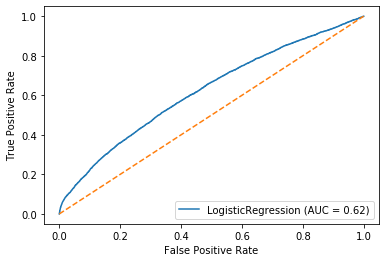

In [22]:
plot_roc_curve(
    lg4,
    X_train,
    y_train,
    sample_weight=None,
    drop_intermediate=True,
    response_method='auto',
    name=None,
    ax=None
)
# plot no skill roc curve
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

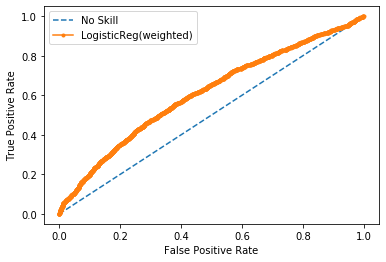

In [91]:
# predict probabilities
yhat = lg4.predict_proba(X_test)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# plot no skill roc curve
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
# calculate roc curve for model
fpr, tpr, _ = roc_curve(y_test, pos_probs)
# plot model roc curve
plt.plot(fpr, tpr, marker='.', label="LogisticReg(weighted)")
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

### Plot Confusion Matrix


confusion_matrix
[[6288 9771]
 [ 281  823]]
confusion matrix
[[6288 9771]
 [ 281  823]]
confusion matrix
[[0.39155614 0.60844386]
 [0.25452899 0.74547101]]


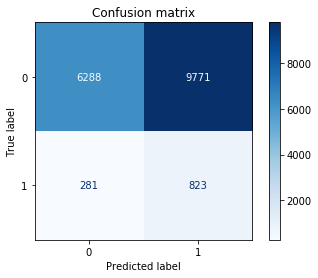

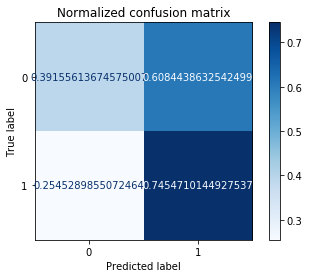

In [92]:
conf_mat=confusion_matrix(y_test, lg4.predict(X_test))
print('confusion_matrix')
print(conf_mat)

 # Plot non-normalized confusion matrix
titles_options = [("Confusion matrix", None),
              ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(lg4, X_test, y_test,
                             cmap=plt.cm.Blues,
                             normalize=normalize,values_format = '' )
    disp.ax_.set_title(title)
    print("confusion matrix")
    print(disp.confusion_matrix)

plt.show()  

### LR Model Feature importance
The positive scores indicate a feature that predicts class 1, whereas the negative scores indicate a feature that predicts class 0

Feature: 0, Score: 0.01515
Feature: 1, Score: -0.03882
Feature: 2, Score: 0.00091
Feature: 3, Score: 0.01194
Feature: 4, Score: -0.04467
Feature: 5, Score: -0.04041
Feature: 6, Score: 0.04621
Feature: 7, Score: 0.01981
Feature: 8, Score: -0.11751
Feature: 9, Score: -0.03941
Feature: 10, Score: -0.00139
Feature: 11, Score: 0.05867
Feature: 12, Score: -0.00017
Feature: 13, Score: -0.00509
Feature: 14, Score: 0.00730
Feature: 15, Score: -0.02660
Feature: 16, Score: 0.03104
Feature: 17, Score: 0.03357
Feature: 18, Score: 0.00402
Feature: 19, Score: 0.03235


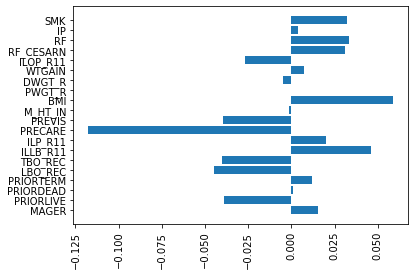

In [23]:
# get importance
importance = lg4.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.barh([x for x in X_train.columns], importance)
#plt.bar([x for x in range(len(importance))], importance)
plt.xticks(rotation='vertical')
plt.show()

<BarContainer object of 20 artists>

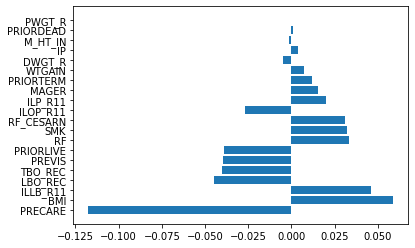

In [24]:
## Sorting important features vbased on its abs values of weightage

d = dict(zip(X_train.columns,(importance))) 
from collections import OrderedDict
def keyfunc(t):
    return abs(t[1])

out = OrderedDict(sorted(d.items(), key=keyfunc,reverse=True))
out1= dict(out)
keys1 = list(out1.keys())
values1 = list(out1.values())

# plot feature importance
plt.barh(keys1, values1)


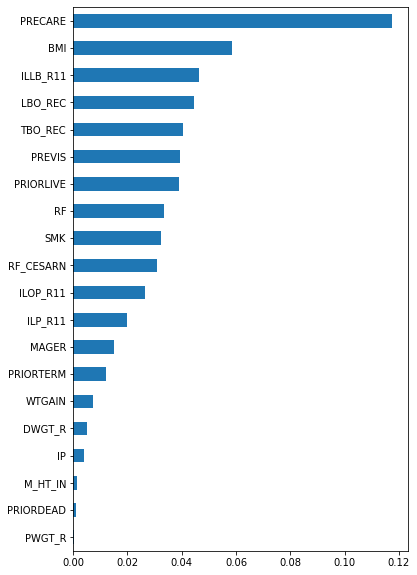

In [26]:
ff = pd.DataFrame.from_dict(d,orient='index',
                       columns=['A'])

ff['abs_imp']= abs(ff['A'])

#plt.barh(ff.index, ff.abs_imp)

dff= ff.iloc[0:20,:]
plt.figure(figsize=(6,10))
ax = plt.subplot()
dff.sort_values('abs_imp', ascending=True)[['abs_imp']].plot.barh(ax=ax)
ax.get_legend().remove()

### ROC curve

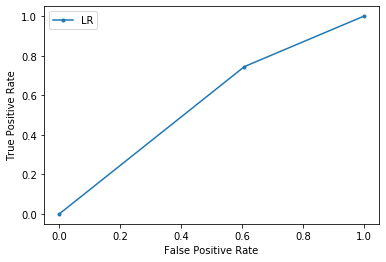

In [96]:
fpr, tpr, thresholds = roc_curve(y_test, lg4.predict(X_test),pos_label=1)
          
    # plot model roc curve
plt.plot(fpr, tpr, marker='.', label='LR')
    # axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
    # show the legend
plt.legend()
    # show the plot
plt.show()      
          

## Prediction-Recall vs Threshold

(0, 1)

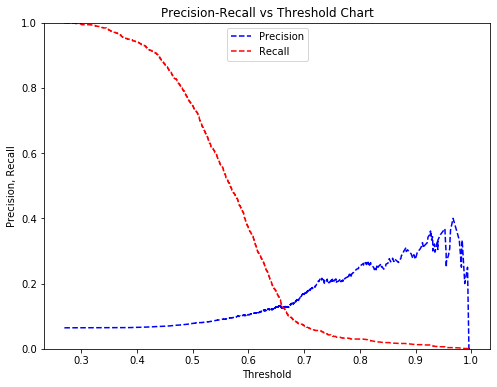

In [97]:
predictions_lr = lg4.predict_proba(X_test)

precision, recall, thresholds = precision_recall_curve(y_test, predictions_lr[:,1])
plt.figure(figsize=(8,6))
plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="upper center")
plt.ylim([0,1])

In [98]:
## using threshold 0.6
THRESHOLD = 0.4
predictions_lr = np.where(lg4.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)


print(confusion_matrix(y_test, predictions_lr))
print()
print(classification_report(y_test, predictions_lr))

[[ 1293 14766]
 [   65  1039]]

              precision    recall  f1-score   support

           0       0.95      0.08      0.15     16059
           1       0.07      0.94      0.12      1104

    accuracy                           0.14     17163
   macro avg       0.51      0.51      0.14     17163
weighted avg       0.90      0.14      0.15     17163



In [109]:
selector =RFE(lg4, n_features_to_select=5, step=1, verbose=0)

In [110]:
selector.fit(X_train, y_train)

C:\Users\rdeo\anaconda3\envs\insight_prj\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\rdeo\anaconda3\envs\insight_prj\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

RFE(estimator=LogisticRegression(C=13.0, class_weight={0: 1, 1: 18}, dual=False,
                                 fit_intercept=True, intercept_scaling=1,
                                 l1_ratio=None, max_iter=100,
                                 multi_class='auto', n_jobs=None, penalty='l2',
                                 random_state=13, solver='lbfgs', tol=0.0001,
                                 verbose=0, warm_start=False),
    n_features_to_select=5, step=1, verbose=0)

In [111]:
print("Num Features: %d" % selector.n_features_)
print("Selected Features: %s" % selector.support_)
print("Feature Ranking: %s" % selector.ranking_)

Num Features: 5
Selected Features: [False False  True False  True False False False False False False False
 False False False False  True  True  True False]
Feature Ranking: [12  2  1  6  1  7  4 11  3  5 15  9 16 14 13 10  1  1  1  8]


In [114]:
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# feature extraction
test = SelectKBest(score_func=f_classif, k=4)
fit = test.fit(X_train, y_train)
# summarize scores
set_printoptions(precision=3)
print(fit.scores_)
features = fit.transform(X_train)
# summarize selected features
print(features[0:5,:])

[7.568e+00 1.800e+02 8.085e-01 1.129e+00 2.005e+02 1.625e+02 2.583e+02
 1.726e+02 1.658e+02 1.455e+01 1.484e+01 4.671e+01 2.415e+01 2.026e+01
 8.643e-01 1.557e-03 1.112e+02 2.049e+02 6.206e+01 4.279e+02]
[[2. 5. 0. 0.]
 [3. 6. 0. 0.]
 [4. 4. 0. 0.]
 [1. 9. 0. 1.]
 [1. 9. 0. 0.]]


In [115]:
from sklearn.decomposition import PCA

# feature extraction
pca = PCA(n_components=3)
fit = pca.fit(X_train)
# summarize components
print("Explained Variance: %s" % fit.explained_variance_ratio_)
print(fit.components_)

Explained Variance: [0.846 0.102 0.016]
[[ 1.109e-02  4.007e-03  6.554e-05  1.275e-03  3.678e-03  4.487e-03
  -2.462e-03 -3.026e-03 -1.012e-03  6.013e-03  2.118e-02  1.009e-01
   7.038e-01  7.027e-01  7.326e-04 -2.098e-03  2.516e-04  2.192e-04
  -1.025e-05  3.631e-04]
 [ 5.616e-03 -1.377e-02 -2.671e-04 -1.296e-03 -1.306e-02 -1.324e-02
   1.484e-02  1.317e-02 -7.689e-03  3.976e-02  2.765e-02 -8.817e-02
  -4.041e-01  4.156e-01  8.078e-01  1.060e-03 -3.375e-04 -6.586e-04
  -4.687e-05 -1.567e-02]
 [-2.092e-01 -3.466e-02 -2.820e-04 -6.012e-03 -3.118e-02 -3.303e-02
   2.245e-02  2.540e-02 -2.254e-03 -5.930e-02 -1.234e-02  8.138e-03
  -5.598e-03  8.912e-03  1.467e-02  1.485e-02  2.464e-04  6.791e-04
   1.401e-03  9.734e-01]]


## L1 Regularization

In [120]:
# define model with best parameters 
lg5 = LogisticRegression(solver='liblinear', random_state=13,C=13.0,fit_intercept=True, penalty='l1',class_weight={0: 1, 1: 15} )
# fit it
lg5.fit(X_train,y_train)
# test
y_pred = lg5.predict(X_test)
# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}') # 0.5
print(f'Recall score: {recall_score(y_test,y_pred)}')

Accuracy Score: 0.6102080055934277
Confusion Matrix: 
[[9832 6227]
 [ 463  641]]
Area Under Curve: 0.5964291491700441
Recall score: 0.5806159420289855


C:\Users\rdeo\anaconda3\envs\insight_prj\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Feature: 0, Score: 0.01297
Feature: 1, Score: 0.08959
Feature: 2, Score: 0.10814
Feature: 3, Score: 0.05654
Feature: 4, Score: -0.13261
Feature: 5, Score: -0.10029
Feature: 6, Score: 0.04749
Feature: 7, Score: 0.01961
Feature: 8, Score: -0.11701
Feature: 9, Score: -0.04452
Feature: 10, Score: -0.00896
Feature: 11, Score: 0.04013
Feature: 12, Score: 0.00432
Feature: 13, Score: -0.00691
Feature: 14, Score: 0.01032
Feature: 15, Score: -0.02731
Feature: 16, Score: 0.57647
Feature: 17, Score: 0.75087
Feature: 18, Score: 0.51249
Feature: 19, Score: 0.02638


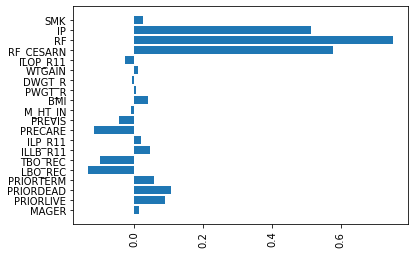

In [118]:
# get importance
importance1 = lg5.coef_[0]
# summarize feature importance
for i,v in enumerate(importance1):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.barh([x for x in X_train.columns], importance1)
#plt.bar([x for x in range(len(importance))], importance)
plt.xticks(rotation='vertical')
plt.show()

<BarContainer object of 20 artists>

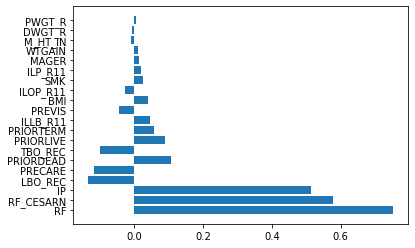

In [119]:
## Sorting important features vbased on its abs values of weightage

d = dict(zip(X_train.columns,(importance1))) 
from collections import OrderedDict
def keyfunc(t):
    return abs(t[1])

out11 = OrderedDict(sorted(d.items(), key=keyfunc,reverse=True))
out2= dict(out11)
keys11 = list(out2.keys())
values11 = list(out2.values())

# plot feature importance
plt.barh(keys11, values11)


## Scaling the data and evaluating the performance of tuned LR model

In [123]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.fit_transform(X_test)

# define model with best parameters 
lg4 = LogisticRegression(random_state=13,C=13.0,fit_intercept=True, penalty='l2',class_weight={0: 1, 1: 18} )
# fit it
lg4.fit(X_train_scl,y_train)
# test
y_pred = lg4.predict(X_test_scl)
# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}') # 0.5
print(f'Recall score: {recall_score(y_test,y_pred)}')

Accuracy Score: 0.5416885159937074
Confusion Matrix: 
[[8574 7485]
 [ 381  723]]
Area Under Curve: 0.5943987625792932
Recall score: 0.654891304347826


C:\Users\rdeo\anaconda3\envs\insight_prj\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
